<a href="https://colab.research.google.com/github/KanhaKorgaonkar/clothing-detection-cnn/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch # deep learning library
import torchvision # provides datasets and image transformations
import torchvision.transforms as transforms
import torchvision.datasets as datasets
# neural network
import torch.nn as nn
#import non linear functions like ReLu
import torch.nn.functional as F
# computational graph for backpropogation (taking the error rate of forward propogation and mitigating it later)
from torch.autograd import Variable

In [3]:
# initializing hyperparameters
num_epochs = 8 # epoch number is the number of training rounds
num_classes = 10 # num_of classes is the number of types of objects/object classes - like tshirt, trouser, coat, sandal etc
batch_size = 100 # minibatch gradient descent - uses a predefined number of samples from the training set in one epoch.
learning_rate = 0.001 # rate at which algorithm converges to a solution -  if the learning rate is too low, gradient descent will take more time to reach the optima. Conversely, if the learning rate is too big, the gradient descent might start to diverge, and it’ll never reach the optimal solution.

In [72]:
# retrieve the data set
# load the data set
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
  # tensor is the data structure used in ML, it has multiple types, like vector, scalar, matrix
  # input image is first transformed to tensor, and then normalized in R, G and B by mean and standard deviation of 0.5. each data is reduced and divided by 0.5 to have zero mean and unit variance which improves model performance
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


In [73]:
# now to put this in a data loader (object) for better accessibility
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#shuffle is used to remove bias from training data
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



In [88]:
# Constructing the Convolutional Neural Network
class CNNModel(nn.Module):
  # nn.Module is the base class of all layered neural network modules
  # this convolutional neural network features two convolutional layers each followed by a nonlinear function (RectifiedLinearuUnit) and a max pooling layer followed by a fullyconnected layer and softmax (assigning probabilities) for linear regression.
  def __init__(self):
    super(CNNModel, self).__init__()

    # Convolution 1
    # 1 input channel (grayscale image), produces 16 output channels
    # the convolution kernel size = 5x5, padding of 2 is added to preserve spatial dimensions
    # stride = 1 so that convolution kernel moves one pixel at a time
    self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
    # relu rectified linear unit layer introduces non linearity and allows it to learn complex patterns but its expensive
    self.relu1 = nn.ReLU()

    # Max Pool 1 - pooling reduces the kernel size/spatial dimensions by half
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    # Convolution 2
    self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
    self.relu2 = nn.ReLU()

    # Max Pool 2
    self.maxpool2 = nn.MaxPool2d(kernel_size = 2)

    # Dropout for Regularization before the fully connected layer to make sure that there's no overfitting
    self.dropout = nn.Dropout(p=0.5)

    # Fully Connected Layer 1 - multiply number of outputs by spatial dimensions, 10 is the number of classes for the classification
    self.fc1 = nn.Linear(32*7*7, 10)

  def forward(self, x):
  # applying each layer to the input + dropout data for forward propagation
  # convolution 1
    out = self.cnn1(x)
    out = self.relu1(out)

    # Max Pool 1
    out = self.maxpool1(out)

    # Conv 2
    out = self.cnn2(out)
    out = self.relu2(out)

    #Max Pool 2
    out = self.maxpool2(out)

    #resize - flatten the data to one dimension
    out = out.view(out.size(0), -1)
    #dropout
    out = self.dropout(out)

    #fully connected 1
    out = self.fc1(out)
    return out



In [89]:
model = CNNModel()
# creating instance of class (we've created a class to determine the layers and forward propagation of a CNN, but we haven't yet created a neural net)

In [90]:
criterion = nn.CrossEntropyLoss()
# cross entropy loss lets us deterimine the labels from the output of the neural net

# From ChatGPT:
#In a classification task, the output of a neural network is typically a vector of scores or logits representing the predicted probabilities for each class. These scores can be interpreted as the model's confidence or belief in the input belonging to each class.
#The cross-entropy loss function, when used in conjunction with softmax activation, helps to determine the most probable label for a given input based on the predicted scores. Here's a step-by-step explanation of how it works:
# Softmax activation: The first step is to apply the softmax activation function to the output scores. Softmax converts the scores into a probability distribution over the classes, ensuring that the predicted values sum up to 1 and are between 0 and 1. This distribution represents the model's predicted probabilities for each class.
# Target labels: Alongside the input data, you have the target labels that indicate the true class for each input sample. These labels are represented as one-hot encoded vectors, where only the element corresponding to the true class is 1, and the rest are 0.
# Calculating loss: The cross-entropy loss compares the predicted probabilities (obtained from softmax) with the target labels. It calculates the dissimilarity or discrepancy between the predicted distribution and the true distribution of the labels. The loss value is higher when the predicted probabilities deviate from the true labels.
# Minimizing loss: During the training process, the goal is to minimize the cross-entropy loss. This is achieved by adjusting the model's parameters (weights and biases) using optimization techniques like backpropagation and gradient descent. The optimization process updates the model's parameters to improve the agreement between the predicted probabilities and the true labels, ultimately making the model better at classifying the input data.
# In summary, the cross-entropy loss, when used with softmax activation, enables the neural network to output a predicted probability distribution over the classes. By comparing this distribution with the true labels, the loss function guides the training process by quantifying the disagreement between the predictions and the ground truth. Through optimization, the model learns to adjust its parameters to minimize this disagreement and improve its ability to assign correct labels to the input data.


In [91]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
# ADAM = Adaptive Moment Estimation. Optimizer is responsible for adjusting the parameters of the model during training to minimize loss and improve performance. This is used to initialize the softmax function with the learning rate.

In [92]:
# TRAIN THE MODEL
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images)
        labels = Variable(labels)

        # clear the gradients
        optimizer.zero_grad()
        # forward propagation
        outputs = model(images)
        # calculating loss with softmax to obtain cross entropy loss
        loss = criterion(outputs, labels)
        # backward propagation
        loss.backward()
        #updating gradients
        optimizer.step()
        iter += 1

        # total number of labels
        total = labels.size(0)

        #obtaining predictions from max value
        _, predicted = torch.max(outputs.data, 1)

        # calculate the number of correct answers
        correct = (predicted == labels).sum().item()

        # Print loss and accuracy
        if (i+1) % 100 == 0:
          print('✨ Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%' .format(epoch + 1, num_epochs, i + 1, len(train_loader), loss.item(),
                          (correct / total) * 100))

✨ Epoch [1/8], Step [100/600], Loss: 0.6356, Accuracy: 79.00%
✨ Epoch [1/8], Step [200/600], Loss: 0.6904, Accuracy: 72.00%
✨ Epoch [1/8], Step [300/600], Loss: 0.5433, Accuracy: 81.00%
✨ Epoch [1/8], Step [400/600], Loss: 0.4884, Accuracy: 80.00%
✨ Epoch [1/8], Step [500/600], Loss: 0.4662, Accuracy: 81.00%
✨ Epoch [1/8], Step [600/600], Loss: 0.5568, Accuracy: 79.00%
✨ Epoch [2/8], Step [100/600], Loss: 0.4179, Accuracy: 82.00%
✨ Epoch [2/8], Step [200/600], Loss: 0.2346, Accuracy: 93.00%
✨ Epoch [2/8], Step [300/600], Loss: 0.2622, Accuracy: 90.00%
✨ Epoch [2/8], Step [400/600], Loss: 0.3853, Accuracy: 88.00%
✨ Epoch [2/8], Step [500/600], Loss: 0.3399, Accuracy: 84.00%
✨ Epoch [2/8], Step [600/600], Loss: 0.4219, Accuracy: 88.00%
✨ Epoch [3/8], Step [100/600], Loss: 0.4179, Accuracy: 87.00%
✨ Epoch [3/8], Step [200/600], Loss: 0.3154, Accuracy: 88.00%
✨ Epoch [3/8], Step [300/600], Loss: 0.4229, Accuracy: 87.00%
✨ Epoch [3/8], Step [400/600], Loss: 0.3210, Accuracy: 88.00%
✨ Epoch 

In [93]:
# now test the model!
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in test_loader:
    images = Variable(images)
    labels = Variable(labels)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Test Accuracy of the model on the 10000 test images: {}%'.format(100*correct/total))

Test Accuracy of the model on the 10000 test images: 89.18%


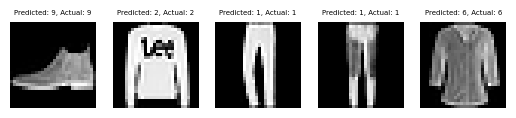

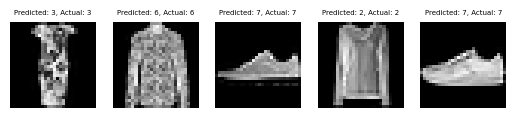

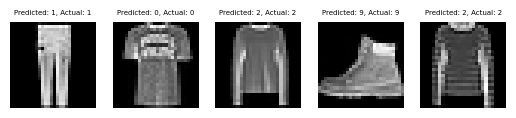

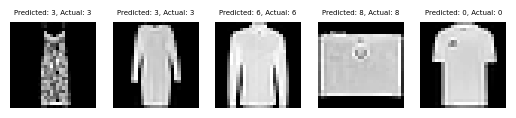

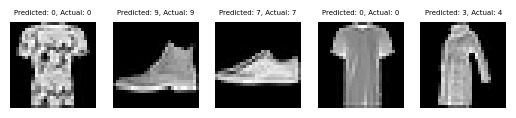

In [107]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Iterate over a few samples from the test dataset
num_samples = 5
for i, (images, labels) in enumerate(test_loader):
    # Forward propagation
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Convert tensors to numpy arrays
    images = images.numpy()
    labels = labels.numpy()
    predicted = predicted.numpy()

    # Plot the images and display the predictions
    for j in range(num_samples):
        plt.subplot(1, num_samples, j+1)
        plt.imshow(images[j].squeeze(), cmap='gray')
        plt.title(f"Predicted: {predicted[j]}, Actual: {labels[j]}", fontsize=5)
        plt.axis('off')
    plt.show()

    # Display only a few samples
    if i == num_samples - 1:
        break